.

# Rescheduling with Deviation (vgl Wu)
> hier das Rescheduling (vereinfacht ohne neue Jobs) unter Berücksichtigung der Abweichung ausprobiert

**1. Abweichung vom Originalplan** - verändert auf Operationen-Ebene (statt Jobs)

$$
D_{0}(\sigma)
\;=\;
\sum_{o \in O'} \bigl|\;t_{o}(\sigma) - t_{o}^{0}\bigr|
\;=\;
\sum_{j \in J'} \;\sum_{m \in M}\;
\bigl|\;t_{j m}(\sigma) - t_{j m}^{0}\bigr|
$$

* $D_{0}(\sigma)$: Schedule-Deviation-Maß auf Operationsebene (Abweichung vom Originalplan)  
* $O'$: Menge aller Operationen, die nach dem Störereignis noch nicht begonnen haben  
* $J'$: Menge aller Jobs, die nach dem Störereignis noch nicht begonnen haben  
* $M$:  Menge aller Maschinen  
* $t_{o}(\sigma)$: neue Startzeit der Operation $o$ im Rescheduling-Plan $\sigma$  
* $t_{o}^{0}$: ursprünglich geplante Startzeit der Operation $o$ im Originalplan  
* $t_{j m}(\sigma)$: neue Startzeit der Operation von Job $j$ auf Maschine $m$ im Plan $\sigma$  
* $t_{j m}^{0}$: ursprünglich geplante Startzeit dieser Operation im Originalplan  


**2. Abweichung vom Right-Shift-Plan** - verändert auf Operationen-Ebene (statt Jobs)

$$
D_{1}(\sigma)
\;=\;
\sum_{o \in O'} \bigl|\;t_{o}(\sigma) - t'_{o}\bigr|
\;=\;
\sum_{j \in J'} \sum_{m \in M}
\bigl|\;t_{j m}(\sigma) - t'_{j m}\bigr|
$$

* $D_{1}(\sigma)$: Schedule-Deviation-Maß auf Operationsebene (Abweichung vom Right-Shift-Plan)  
* $O'$: Menge aller Operationen, die nach dem Störereignis noch nicht begonnen haben  
* $J'$: Menge aller Jobs, die nach dem Störereignis noch nicht begonnen haben  
* $M$:  Menge aller Maschinen  
* $t_{o}(\sigma)$: neue Startzeit der Operation $o$ im Rescheduling-Plan $\sigma$  
* $t'_{o}$: geplante Startzeit der Operation $o$ im Right-Shift-Plan  
* $t_{j m}(\sigma)$: neue Startzeit der Operation von Job $j$ auf Maschine $m$ im Plan $\sigma$  
* $t'_{j m}$: geplante Startzeit dieser Operation im Right-Shift-Plan  


## Datensatz laden und generieren

In [49]:
import json
import pandas as pd
pd.set_option('display.max_rows', 20)

# Basics
import utils.basics.presenter as show
import utils.basics.converter as convert

import utils.checker as check
from ProductionDaySimulation import ProductionDaySimulation

In [9]:
import utils.rolling_planning.init_jobs_times as rp_init
import utils.rolling_planning.procedure as rp_proced

In [10]:
import utils.schedule_solver__arrival as ssv_a

In [11]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)

df_jssp, df_times = rp_init.init_jobs_with_arrivals(df_instance, 2,  u_b_mmax = 0.9)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
375,Job_037,5,M9,76
376,Job_037,6,M5,47
377,Job_037,7,M3,52
378,Job_037,8,M4,90


In [12]:
df_times

,Job,Arrival
0,Job_000,0.00
1,Job_001,88.05
2,Job_002,152.78
3,Job_003,207.97
4,Job_004,246.61
...,...,...
33,Job_033,2630.89
34,Job_034,2637.28
35,Job_035,2638.72
36,Job_036,2764.04


In [13]:
solver_limit = 60*25
solver_limit

1500

In [55]:
file_template = "data/{prefix}_schedule_{suffix}.csv"

## I. Makespan Verfahren

> Startet zu spät, keine/wenige Ops in Zeitfenster

## II. Flowtime Verfahren (gewichtet)

### a) Ursprünglicher Plan (alles)

In [18]:
df_plan = ssv_a.solve_jssp_weighted_individual_flowtime(df_jssp, df_times , solver_time_limit=solver_limit, epsilon=0.06)
df_plan

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,29,29.00,29.00
1,Job_000,1,0.00,M1,29.00,78,107.00,107.00
2,Job_000,2,0.00,M2,107.00,9,116.00,116.00
3,Job_000,3,0.00,M3,116.00,36,152.00,152.00
4,Job_000,4,0.00,M4,152.00,49,201.00,201.00
...,...,...,...,...,...,...,...,...
375,Job_037,5,2869.61,M9,4483.60,76,1689.99,4559.60
376,Job_037,6,2869.61,M5,4559.60,47,1736.99,4606.60
377,Job_037,7,2869.61,M3,4730.72,52,1913.11,4782.72
378,Job_037,8,2869.61,M4,4782.72,90,2003.11,4872.72


In [61]:
df_plan.to_csv(file_template.format(prefix="05", suffix="00_original"), index = False)

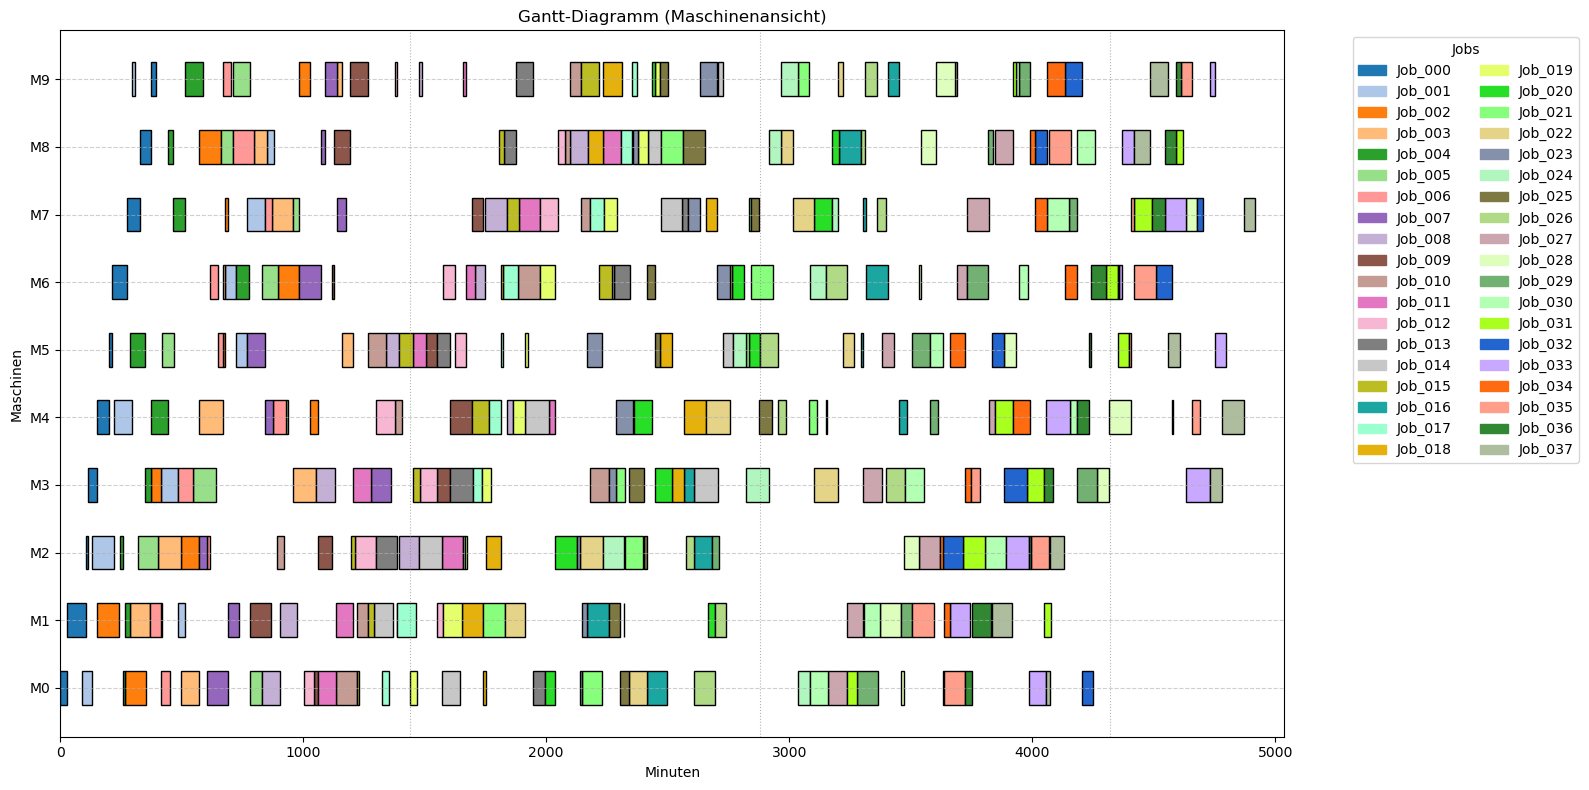

In [19]:
show.plot_gantt_machines(df_plan)

#### Simulation

In [21]:
day_start = 0
day_end = 1440

filt = (df_plan["Start"] >=  day_start) & (df_plan["Start"] < day_end)
df_schedule_filtered = df_plan[filt]
df_schedule_filtered

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,29,29.00,29.00
1,Job_000,1,0.00,M1,29.00,78,107.00,107.00
2,Job_000,2,0.00,M2,107.00,9,116.00,116.00
3,Job_000,3,0.00,M3,116.00,36,152.00,152.00
4,Job_000,4,0.00,M4,152.00,49,201.00,201.00
...,...,...,...,...,...,...,...,...
151,Job_015,1,1197.28,M0,1221.80,6,30.52,1227.80
152,Job_015,2,1197.28,M1,1267.80,22,92.52,1289.80
153,Job_015,3,1197.28,M5,1392.86,61,256.58,1453.86
170,Job_017,0,1324.04,M0,1324.04,29,29.00,1353.04


In [22]:
df_schedule_filtered

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,29,29.00,29.00
1,Job_000,1,0.00,M1,29.00,78,107.00,107.00
2,Job_000,2,0.00,M2,107.00,9,116.00,116.00
3,Job_000,3,0.00,M3,116.00,36,152.00,152.00
4,Job_000,4,0.00,M4,152.00,49,201.00,201.00
...,...,...,...,...,...,...,...,...
151,Job_015,1,1197.28,M0,1221.80,6,30.52,1227.80
152,Job_015,2,1197.28,M1,1267.80,22,92.52,1289.80
153,Job_015,3,1197.28,M5,1392.86,61,256.58,1453.86
170,Job_017,0,1324.04,M0,1324.04,29,29.00,1353.04


In [73]:
simulation = ProductionDaySimulation(df_schedule_filtered, vc=0.45)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:28:30] Job_000 finished on M0 (after 28 minutes 30 seconds)
[00:29:00] Job_000 started on M1
[01:28:02] Job_001 started on M0
[02:05:36] Job_001 finished on M0 (after 37 minutes 34 seconds)
[02:11:03] Job_001 started on M2
[02:26:10] Job_000 finished on M1 (after 117 minutes 10 seconds)
[02:32:46] Job_002 started on M1
[02:52:00] Job_001 finished on M2 (after 40 minutes 58 seconds)
[02:52:00] Job_000 started on M2
[03:11:58] Job_000 finished on M2 (after 19 minutes 58 seconds)
[03:11:58] Job_000 started on M3
[03:41:03] Job_001 started on M4
[03:55:01] Job_000 finished on M3 (after 43 minutes 02 seconds)
[03:59:18] Job_002 finished on M1 (after 86 minutes 31 seconds)
[04:06:36] Job_004 started on M2
[04:16:34] Job_004 finished on M2 (after 09 minutes 58 seconds)
[04:20:36] Job_004 started on M0
[04:30:03] Job_004 finished on M0 (after 09 minutes 27 seconds)
[04:30:03] Job_002 started on M0
[04:30:03] Job_004 started on M1
[04:30:49] Job_001 finished

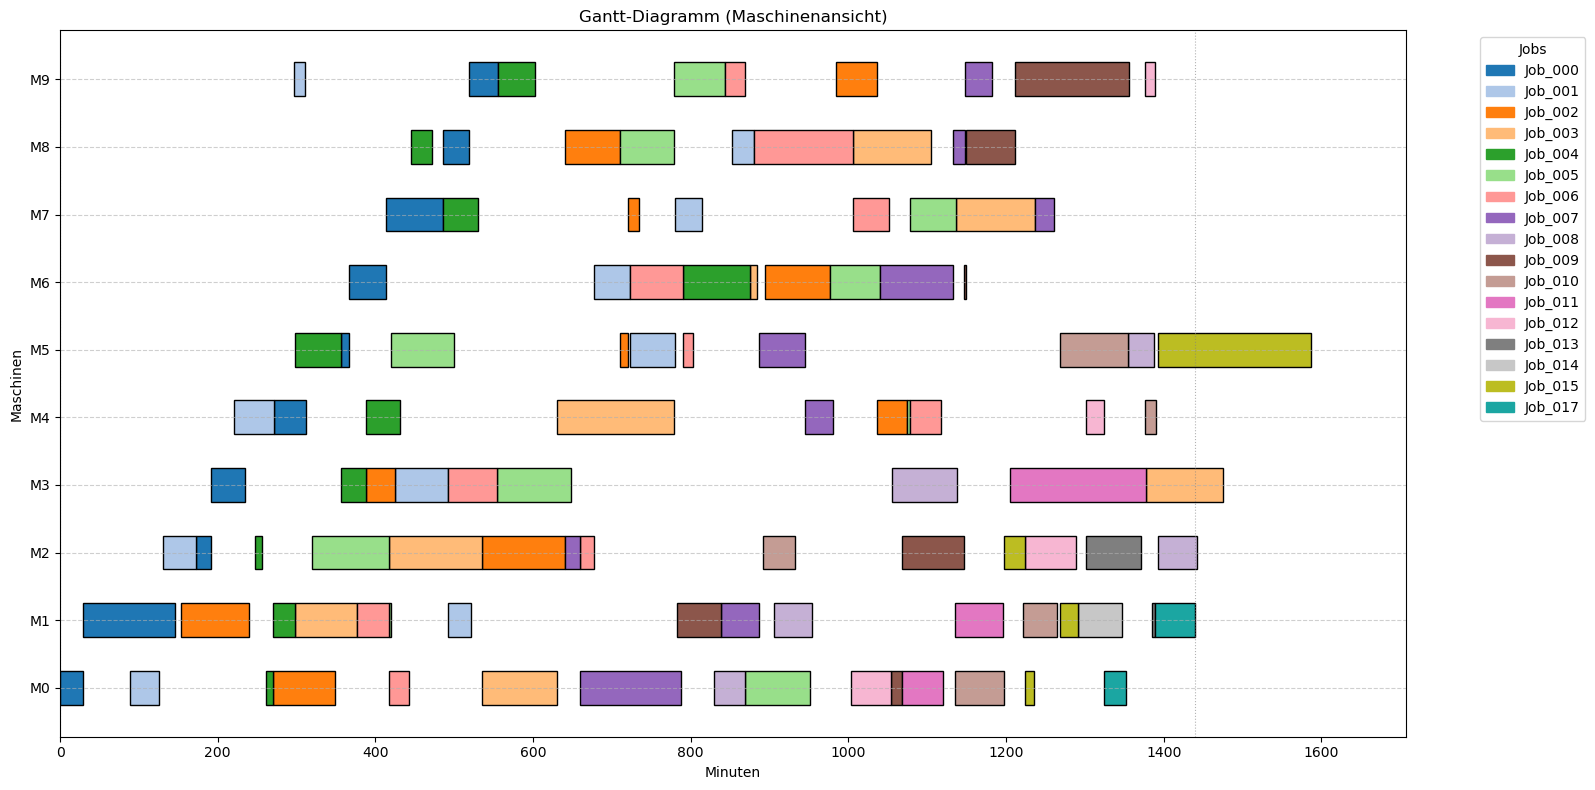

In [75]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, duration_column="Simulated Processing Time")
else:
    print("⚠️ Kein Gantt-Diagramm: df_execution ist leer.")

In [76]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_003,8,207.97,M9,1138.75,22
1,Job_003,9,207.97,M5,1160.75,43
2,Job_007,9,515.63,M3,1280.74,79


### b) Plan nach Simulation (Rescheduling)

In [80]:
# Filtern (nach Simulation)
day_end_prev = day_end


time_filter = (df_times["Arrival"] >= day_end_prev)

df_times_filtered = df_times[time_filter]


df_jssp_filtered = df_jssp[df_jssp["Job"].isin(df_times_filtered["Job"])]
df_jssp_filtered

,Job,Operation,Machine,Processing Time
190,Job_019,0,M0,29
191,Job_019,1,M1,78
192,Job_019,2,M2,9
193,Job_019,3,M3,36
194,Job_019,4,M4,49
...,...,...,...,...
375,Job_037,5,M9,76
376,Job_037,6,M5,47
377,Job_037,7,M3,52
378,Job_037,8,M4,90


In [82]:
# Nicht gestarte Operationen ergänzen
df_jssp_filtered = rp_proced.extend_with_undone_operations(df_jssp_filtered, df_undone)
df_jssp_filtered

C:\Users\konra\Coding\Master\HTWD_JSSP\02_Mai\utils\rolling_planning\procedure.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jssp_todo['Job'] = df_jssp_todo['Job'].astype(str)


,Job,Operation,Machine,Processing Time
0,Job_003,8,M9,22
1,Job_003,9,M5,43
2,Job_007,9,M3,79
3,Job_019,0,M0,29
4,Job_019,1,M1,78
...,...,...,...,...
188,Job_037,5,M9,76
189,Job_037,6,M5,47
190,Job_037,7,M3,52
191,Job_037,8,M4,90


In [115]:
df_times_filtered = rp_proced.update_times_after_operation_changes(df_times, df_jssp_filtered)
df_times_filtered

,Job,Arrival
0,Job_003,207.97
1,Job_007,515.63
2,Job_019,1440.00
3,Job_020,1528.05
4,Job_021,1592.78
...,...,...
16,Job_033,2630.89
17,Job_034,2637.28
18,Job_035,2638.72
19,Job_036,2764.04


In [117]:
# relevante Bedingungen aus der Simulation
df_execution_important = rp_proced.get_operations_running_into_day(df_execution, day_end_prev)
df_execution_important

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
37,Job_003,7,207.97,M3,1377.23,98.11,1267.37,1475.34
81,Job_008,4,748.04,M2,1392.80,49.62,694.38,1442.42
106,Job_015,3,1197.28,M5,1392.86,194.50,390.08,1587.36


In [119]:
import pandas as pd
import pulp
import re

def solve_jssp_bi_criteria_flowtime_deviation_with_fixed_ops(
    df_jssp: pd.DataFrame,
    df_arrivals: pd.DataFrame,
    df_executed: pd.DataFrame,
    df_original_plan: pd.DataFrame,
    r: float = 0.5,
    solver_time_limit: int = 300,
    epsilon: float = 0.0,
    arrival_column: str = "Arrival",
    reschedule_start: float = 1440.0
) -> pd.DataFrame:
    """
    Bi-kriterielle Rescheduling-Variante mit fixierten Operationen.
    Zielfunktion: Z(σ) = r * F(σ) + (1 - r) * D(σ)
    - F(σ): gewichtete individuelle Flow-Times
    - D(σ): Abweichung vom Originalplan

    Parameter:
    - df_jssp: DataFrame mit ['Job','Operation','Machine','Processing Time']
    - df_arrivals: DataFrame mit ['Job', arrival_column]
    - df_executed: DataFrame mit ['Job','Machine','Start','End']
    - df_original_plan: DataFrame mit ['Job','Operation','Start'] als Ursprungsplan
    - r: Gewichtung für Effizienz (F) vs. Stabilität (D)
    - solver_time_limit: max. Solverzeit in Sekunden
    - epsilon: Zeitpuffer zwischen Operationen auf gleicher Maschine
    - arrival_column: Name der Spalte mit Ankunftszeit
    - reschedule_start: Zeitpunkt, ab dem neu geplant wird

    Rückgabe:
    - df_schedule: DataFrame mit ['Job','Operation','Arrival','Machine','Start','Processing Time','Flow time','End']
    """

    # Vorbereitung
    df_arrivals = df_arrivals.sort_values(arrival_column).reset_index(drop=True)
    arrival_times = df_arrivals.set_index('Job')[arrival_column].to_dict()
    job_list = df_arrivals['Job'].tolist()
    num_jobs = len(job_list)
    weights = {job: 1.0 / (1.0 + arrival_times[job]) for job in job_list}

    # Originale Startzeiten extrahieren
    original_start_times = {
        (row['Job'], row['Operation']): row['Start']
        for _, row in df_original_plan.iterrows()
    }

    # Operationen & Maschinen
    ops_grouped = df_jssp.sort_values(['Job', 'Operation']).groupby('Job')
    all_ops, all_machines = [], set()
    for job in job_list:
        grp = ops_grouped.get_group(job)
        ops = []
        for _, row in grp.iterrows():
            op_id = row['Operation']
            mac_str = str(row['Machine'])
            m_id = int(re.search(r"M(\d+)", mac_str).group(1))
            dur = float(row['Processing Time'])
            ops.append((op_id, m_id, dur))
            all_machines.add(m_id)
        all_ops.append(ops)

    # Fixierte Operationen
    df_executed_fixed = df_executed[df_executed['End'] >= reschedule_start].copy()
    df_executed_fixed['MachineID'] = df_executed_fixed['Machine'].astype(str).str.extract(r"M(\d+)", expand=False).astype(int)
    fixed_ops = {
        m: list(gr[['Start', 'End', 'Job']].itertuples(index=False, name=None))
        for m, gr in df_executed_fixed.groupby('MachineID')
    }
    last_executed_end = df_executed.groupby('Job')['End'].max().to_dict()

    # LP-Modell
    prob = pulp.LpProblem('JSSP_BiCriteria_FlowDeviation_Fixed', pulp.LpMinimize)

    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0)
        for j in range(num_jobs)
        for o in range(len(all_ops[j]))
    }
    job_ends = {
        j: pulp.LpVariable(f"job_end_{j}", lowBound=0)
        for j in range(num_jobs)
    }

    # Flow-Teil der Zielfunktion
    flow_efficiency = pulp.lpSum(
        weights[job_list[j]] * (job_ends[j] - arrival_times[job_list[j]])
        for j in range(num_jobs)
    )

    # Abweichungs-Teil der Zielfunktion
    deviations = {}
    for (j, o) in starts:
        job = job_list[j]
        key = (job, o)
        if key in original_start_times:
            dev = pulp.LpVariable(f"dev_{j}_{o}", lowBound=0)
            prob += dev >= starts[(j, o)] - original_start_times[key]
            prob += dev >= original_start_times[key] - starts[(j, o)]
            deviations[(j, o)] = dev
    deviation = pulp.lpSum(deviations.values())

    # Kombinierte Zielfunktion
    prob += r * flow_efficiency + (1 - r) * deviation

    # Technologische Reihenfolge + frühester Start
    for j, job in enumerate(job_list):
        earliest = max(arrival_times[job], last_executed_end.get(job, reschedule_start))
        prob += starts[(j, 0)] >= earliest
        for o in range(1, len(all_ops[j])):
            _, _, prev_dur = all_ops[j][o-1]
            prob += starts[(j, o)] >= starts[(j, o-1)] + prev_dur

    # Maschinenkonflikte
    M = 1e5
    for m in sorted(all_machines):
        ops_on_m = [
            (j, o, all_ops[j][o][2])
            for j in range(num_jobs)
            for o, (_, mach, _) in enumerate(all_ops[j])
            if mach == m
        ]
        for i in range(len(ops_on_m)):
            j1, o1, d1 = ops_on_m[i]
            for j2, o2, d2 in ops_on_m[i+1:]:
                if j1 == j2:
                    continue
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat='Binary')
                prob += (starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + M*(1 - y))
                prob += (starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + M*y)
        for j1, o1, d1 in ops_on_m:
            for fixed_start, fixed_end, fixed_job in fixed_ops.get(m, []):
                y_fix = pulp.LpVariable(f"y_fix_{j1}_{o1}_{fixed_job}", cat='Binary')
                prob += (starts[(j1, o1)] + d1 + epsilon <= fixed_start + M*(1 - y_fix))
                prob += (fixed_end + epsilon <= starts[(j1, o1)] + M*y_fix)

    # Endzeitbindung pro Job
    for j in range(num_jobs):
        last_o = len(all_ops[j]) - 1
        prob += job_ends[j] >= starts[(j, last_o)] + all_ops[j][last_o][2]

    # Solver starten
    prob.solve(pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit))

    # Ergebnisse sammeln
    recs = []
    for (j, o), var in sorted(starts.items()):
        st = var.varValue
        if st is None:
            continue
        op_id, mach, dur = all_ops[j][o]
        end = st + dur
        recs.append({
            'Job': job_list[j],
            'Operation': op_id,
            'Arrival': arrival_times[job_list[j]],
            'Machine': f"M{mach}",
            'Start': round(st, 2),
            'Processing Time': dur,
            'Flow time': round(end - arrival_times[job_list[j]], 2),
            'End': round(end, 2)
        })

    df_schedule = pd.DataFrame(recs)
    df_schedule = df_schedule[['Job', 'Operation', 'Arrival', 'Machine', 'Start', 'Processing Time', 'Flow time', 'End']]
    df_schedule = df_schedule.sort_values(['Arrival', 'Start']).reset_index(drop=True)
    print("✅ Fertig mit bi-kriteriellem Rescheduling!")
    return df_schedule


In [121]:
df_reschedule = solve_jssp_bi_criteria_flowtime_deviation_with_fixed_ops(
    df_jssp = df_jssp_filtered,
    df_arrivals = df_times_filtered,
    df_executed=df_execution_important,
    df_original_plan=df_plan,
    r = 0.3,  # z. B. 30 % Effizienz, 70 % Stabilität
    solver_time_limit = 60*15,
    reschedule_start = 1440
)
df_reschedule

✅ Fertig mit bi-kriteriellem Rescheduling!


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_003,8,207.97,M9,1475.34,22.0,1289.37,1497.34
1,Job_003,9,207.97,M5,1587.36,43.0,1422.39,1630.36
2,Job_007,9,515.63,M3,1475.34,79.0,1038.71,1554.34
3,Job_019,0,1440.00,M0,1440.00,29.0,29.00,1469.00
4,Job_019,1,1440.00,M1,1576.98,78.0,214.98,1654.98
...,...,...,...,...,...,...,...,...
188,Job_037,5,2869.61,M9,4483.60,76.0,1689.99,4559.60
189,Job_037,6,2869.61,M5,4559.60,47.0,1736.99,4606.60
190,Job_037,7,2869.61,M3,4730.72,52.0,1913.11,4782.72
191,Job_037,8,2869.61,M4,4782.72,90.0,2003.11,4872.72


In [122]:
check.check_all_constraints(df_reschedule)

✅ Keine Maschinenkonflikte gefunden
✅ Für alle Jobs ist die Operationssequenz korrekt.
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

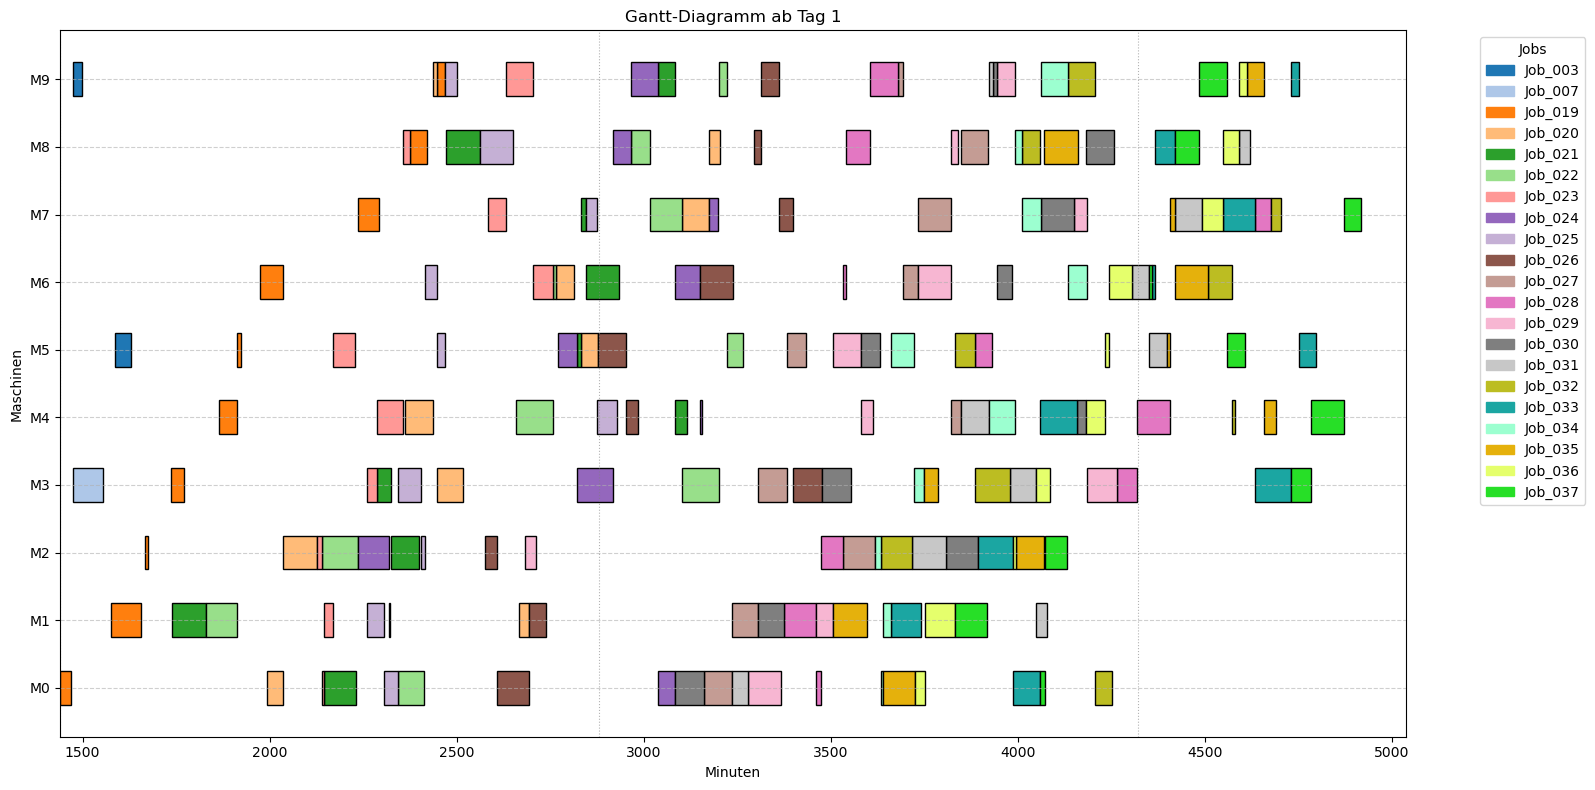

In [125]:
show.plot_gantt_machines(df_reschedule, title = f"Gantt-Diagramm ab Tag 1")

In [126]:
df_reschedule.to_csv(file_template.format(prefix="05", suffix="01_reschedule"), index = False)